In [1]:
!pip install transformers

In [2]:
!pip install catboost

<a id='К_оглавлению'></a>

# Проект для «Викишоп» c BERT

---

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

---

### Разделим данное исследование на несколько частей:

* [Загрузка необходимых библиотек и предобработка](#Загрузка_необходимых_библиотек_и_предобработка)
* [BERT](#BERT)
* [Загрузка и обучение моделей](#Загрузка_и_обучение_моделей)
* [Обучение на CatboostClassifier](#Обучение_на_CatboostClassifier)

---

<a id='Загрузка_необходимых_библиотек_и_предобработка'></a>
### Загрузка необходимых библиотек и предобработка
Загрузим неободимые библиотеки.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb

import re
import torch
import transformers as ppb
from tqdm import notebook 
import warnings

Для ускорения работы я буду работать с помощью *GPU*. Включим его в **GoogleColab** И убедимся, что он работает.

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Загрузим таблицу и изучим ее.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/toxic_comments.csv')

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
df.isnull().sum()

text     0
toxic    0
dtype: int64

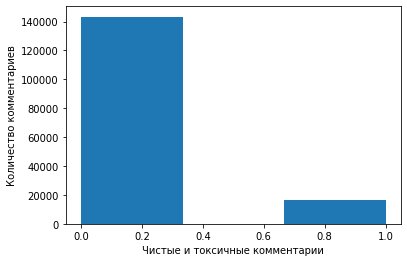

In [9]:
df['toxic'].hist(bins=3, grid=False)
plt.ylabel('Количество комментариев')
plt.xlabel('Чистые и токсичные комментарии')
plt.show()

В таблице очень сильный перевес классов в сторону положительныъ комментариев. Так же присутствуют символы на подобии `'\n'`, которые усложнят обучение модели. Избавимся от них.

In [10]:
df['text'] = df['text'].apply(lambda x: x.replace('\n',' '))

Теперь очистим текст от остальных символов с помощью *регулярных выражений*, а так же приведем весь текст к нижнему регистру.

In [11]:
 def clear(text):  
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return ' '.join(text.split())

In [12]:
df['text'] = pd.DataFrame(df['text'].apply(lambda x: clear(x)))

Для того, что бы обучить модель корректно, нужно избавится от дисбаланса. Я воспользуюсь техникой **downsampling**. Копируем нашу таблицу, для работы с **BERT**.

In [13]:
bert_df = df.copy()

In [14]:
bert_df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Положительные комментарии почти в 10 раз привышают токсичные. Сократим чистые комментарии и реиндексируем таблицу.

In [15]:
bert_df[bert_df['toxic']==0] = bert_df[bert_df['toxic']==0].sample(frac=0.11,random_state=42)

In [16]:
bert_df = bert_df.dropna().reset_index(drop=True)
bert_df['toxic'] = bert_df['toxic'].astype(int)

In [17]:
bert_df['toxic'].value_counts()

1    16225
0    15768
Name: toxic, dtype: int64

In [18]:
bert_df.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,You sir are my hero Any chance you remember wh...,0
2,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
3,Hey what is it talk What is it an exclusive gr...,1
4,Bye Don t look come or think of comming back T...,1


## Вывод
Были загруженны библиотеки, проведена очистка. Так же талица разделена на 2 выборки для последующего обучения. Для таблицы *bert_df* было проведенено уменьшение выборки положительных комментариев.

[К оглавлению](#К_оглавлению)

---

<a id='BERT'></a>
 
 ## BERT 
 Загрузим модель и токенайзер. (https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

In [19]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Токенезируем текст и обрежем максимальную длину предложения для корректной работы **BERT**

In [20]:
tokenized = bert_df['text'].apply((lambda x: tokenizer.encode(x[:511], add_special_tokens=True)))

In [21]:
tokenized

0        [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1        [101, 2017, 2909, 2024, 2026, 5394, 2151, 3382...
2        [101, 10338, 6342, 9102, 2077, 2017, 18138, 21...
3        [101, 4931, 2054, 2003, 2009, 2831, 2054, 2003...
4        [101, 9061, 2123, 1056, 2298, 2272, 2030, 2228...
                               ...                        
31988    [101, 1998, 1045, 1049, 2183, 2000, 2562, 1473...
31989    [101, 2009, 2003, 2026, 5448, 2008, 2008, 6433...
31990    [101, 9260, 1997, 3720, 2302, 10465, 8208, 199...
31991    [101, 2053, 2002, 2106, 2025, 3191, 2009, 2153...
31992    [101, 1998, 2005, 1996, 2117, 2051, 1997, 4851...
Name: text, Length: 31993, dtype: object

Применим метод *padding* для равной длины текстов и создадим маску.

In [22]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [23]:
attention_mask = np.where(padded != 0, 1, 0)

In [24]:
padded.shape

(31993, 277)

Преобразуем а эмбеддинги. Для скорости я буду использовать GPU. Для этого мне понадобится **torch.cuda.LongTensor**.

In [25]:
model = model.cuda()
batch_size = 10
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.cuda.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.cuda.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) 

## Вывод
Был загружен **BERT**, данные токенезированны, а после преобразованны в эмбеддинги.

[К оглавлению](#К_оглавлению)

---

<a id='#Загрузка_и_обучение_моделей'></a>
## Загрузка и обучение моделей

Разделим таблицу изначально на фичи и таргет, а потом на тренировочную и тестовую выборки.

In [26]:
features = np.concatenate(embeddings)
target = bert_df['toxic'].iloc[0:31990]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.3)

Обучим **LogisticRegression**.

In [28]:
param_grid_reg = {
    'solver':['liblinear'],
    'penalty':['l1'],
    'C':[1,0.9],
    'random_state':[42]
}

In [29]:
reg_model = LogisticRegression()
grid_reg = GridSearchCV(estimator=reg_model, param_grid=param_grid_reg, scoring='f1', cv=2)
grid_reg.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 0.9], 'penalty': ['l1'], 'random_state': [42],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [30]:
reg_pred = grid_reg.predict(X_test)

Так же обучим **LGBMClassifier**.

In [31]:
param_grid_lgbm = {
    'num_leaves': [30, 50],
    'n_estimators': [120, 150],
    'metric': ['f1'],
    'random_state':[42]
}

In [32]:
ligt_model = lgb.LGBMClassifier()
grid_reg = GridSearchCV(estimator=ligt_model, param_grid=param_grid_lgbm, scoring='f1', cv=2)
ligt_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
light_pred = ligt_model.predict(X_test)

<a id='Обучение_на_CatboostClassifier'></a>
Так же для сравнения обучим __CatBoostClassifier__ на непреобразованной таблице и проверим результат.

In [34]:
train_tf = bert_df.sample(frac=0.8,random_state=42).copy()
valid_tf = bert_df[~bert_df.index.isin(train_tf.index)].copy()

In [35]:
c_model = CatBoostClassifier(verbose=300,
                           early_stopping_rounds=200, eval_metric='F1', task_type='GPU', random_state=42)

c_model.fit(train_tf[['text']],train_tf[['toxic']],
          eval_set=(valid_tf[['text']],valid_tf[['toxic']]),
          text_features=['text'])

Learning rate set to 0.054055
0:	learn: 0.8642275	test: 0.8669105	best: 0.8669105 (0)	total: 84.5ms	remaining: 1m 24s
300:	learn: 0.9089975	test: 0.8979147	best: 0.8979147 (300)	total: 18.7s	remaining: 43.4s
600:	learn: 0.9166437	test: 0.8999380	best: 0.9005884 (587)	total: 36.2s	remaining: 24s
900:	learn: 0.9228055	test: 0.9025371	best: 0.9029562 (891)	total: 53.5s	remaining: 5.88s
999:	learn: 0.9240779	test: 0.9028766	best: 0.9033555 (966)	total: 59.2s	remaining: 0us
bestTest = 0.9033554971
bestIteration = 966
Shrink model to first 967 iterations.


In [36]:
c_model.best_score_

{'learn': {'F1': 0.9240779210598518, 'Logloss': 0.19360948702576775},
 'validation': {'F1': 0.9033554971393227, 'Logloss': 0.24245571512638694}}

In [37]:
pd.DataFrame({'F1_score':[f1_score(y_test,reg_pred), f1_score(y_test, light_pred), ' 0.903355']},
             index=['LogisticRegression', 'LGBMClassifier', 'CatBoostClassifier'])

,F1_score
LogisticRegression,0.897892
LGBMClassifier,0.887305
CatBoostClassifier,0.903355


## Вывод 
В исследовании было проведено исследования 2х подходов катикорезации комментариев. Модель **BERT** достаточно ресурсозаатратна, но дает хорошие результаты. В то же время **CatBoostClassifier** при меньших затратах времени и кода дает такой же результат. При работе с небольшим объемом данных я бы использовал **CatBoost**.

[К оглавлению](#К_оглавлению)